In [ ]:
! pip install feature_engine
! pip install squarify

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
sns.set(context="notebook", palette="colorblind", style = 'darkgrid' ,font_scale = 2, color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import squarify

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score

from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score

In [ ]:
# read original rfm dataset
rfm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/RFM Analysis with Python/dataset/brazil_ecommerce_rfm_filtered.csv').drop(columns='Unnamed: 0', axis=1)
rfm = rfm.set_index('customer_unique_id')
rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71
af07308b275d755c9edb36a90c618231,35,1,141.46
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12
7c142cf63193a1473d2e66489a9ae977,283,1,72.20
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62


In [ ]:
# read rfm dataset with rfm segment and rfm score
my_rfm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/RFM Analysis with Python/dataset/rfm_segments.csv')
my_rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,1,4,1,141,6
1,af07308b275d755c9edb36a90c618231,35,1,141.46,4,1,3,413,8
2,3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,4,1,3,413,8
3,7c142cf63193a1473d2e66489a9ae977,283,1,72.20,1,1,2,112,4
4,72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,211,4


# Segment customer into 3 part: Top, Middle, Low

With the aim to easier observing RFM trend while creating cluster later


In [ ]:
# Define rfm_level function
# Divide it into 3 level
def get_level(my_rfm):
    if my_rfm['RFM_Score'] >= 10:
        return 'Top'
    elif ((my_rfm['RFM_Score'] >= 6) and (my_rfm['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
my_rfm['RFM_Level'] = my_rfm.apply(get_level, axis=1)
my_rfm.tail()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
69584,a49e8e11e850592fe685ae3c64b40eca,252,1,71.04,1,4,2,142,7,Middle
69585,c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58,1,4,4,144,9,Middle
69586,da62f9e57a76d978d02ab5362c509660,204,1,195.00,2,4,3,243,9,Middle
69587,5097a5312c8b157bb7be58ae360ef43c,232,4,882.32,2,4,4,244,10,Top
69588,60350aa974b26ff12caad89e55993bd6,173,1,86.86,2,4,2,242,8,Middle


In [ ]:
# RFM mean in each RFM_Level
my_rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(3)

,Recency,Frequency,Monetary
RFM_Level,,,
Low,241.738,1.000,66.279
Middle,158.430,1.331,175.986
Top,93.407,3.811,488.201


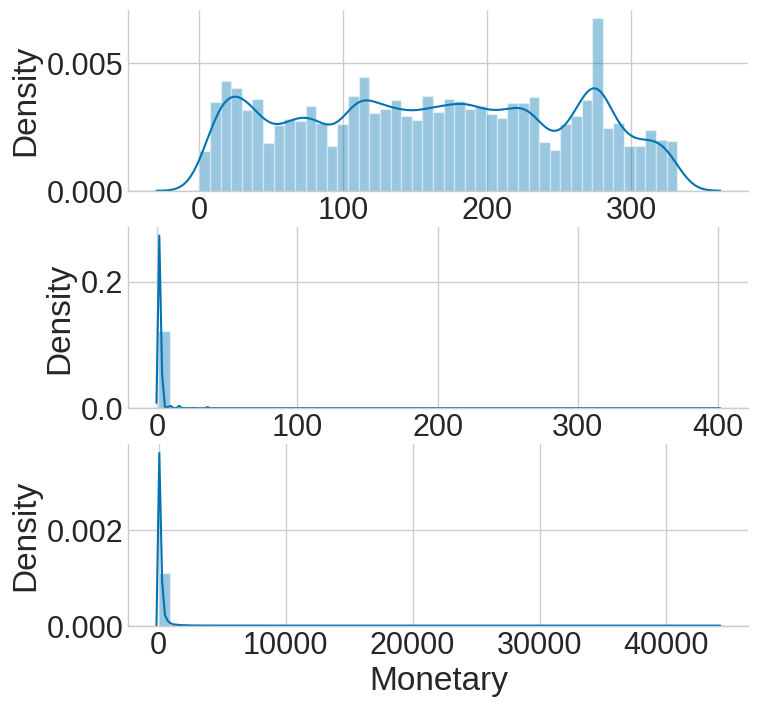

In [ ]:
# distribution of RFM
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(8, 8));
sns.despine(left=False, bottom=False)
sns.distplot(my_rfm['Recency'], ax=ax[0])
sns.distplot(my_rfm['Frequency'], ax=ax[1])
sns.distplot(my_rfm['Monetary'], ax=ax[2])
plt.show()

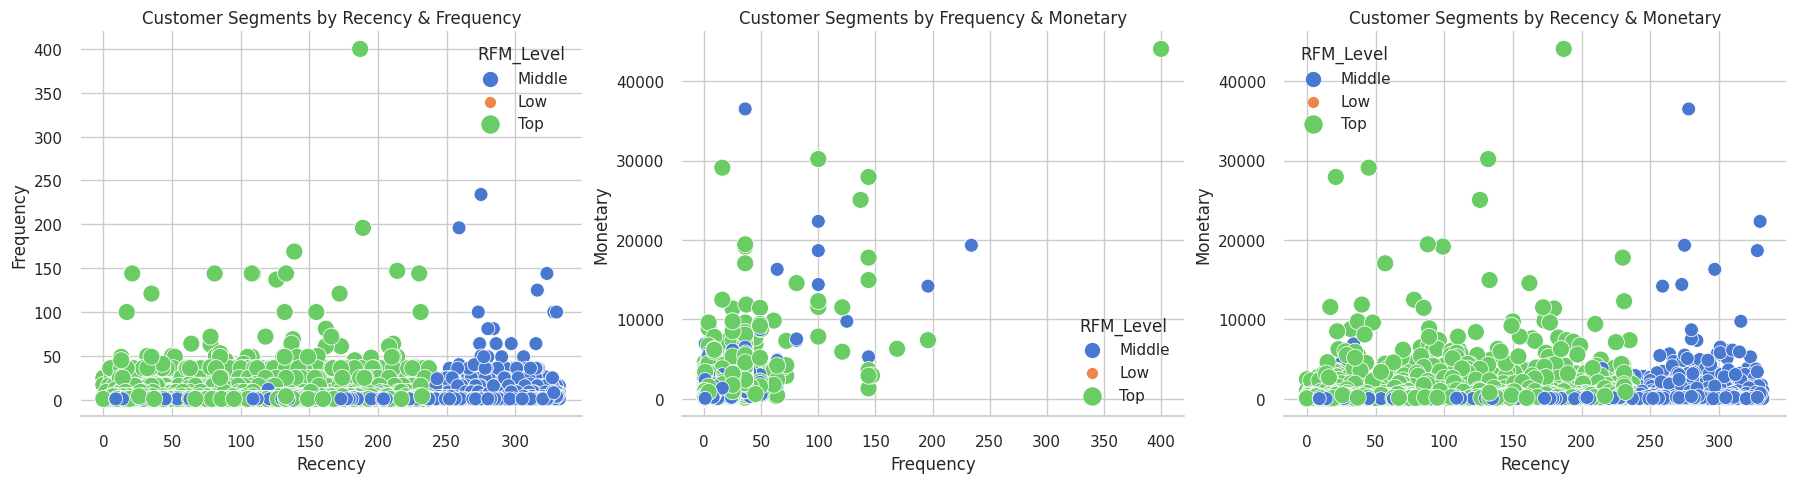

In [ ]:
# plotting the distribution of the RFM
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='RFM_Level', data=my_rfm, size='RFM_Level', sizes=(50,150), size_order=['Top', 'Middle', 'Low'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='RFM_Level', data=my_rfm, size='RFM_Level' , sizes=(50,150), size_order=['Top', 'Middle', 'Low'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='RFM_Level', data=my_rfm, size='RFM_Level' , sizes=(50,150), size_order=['Top', 'Middle', 'Low'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

## Addressing skewness

In [ ]:
# performing log transformation
rfm_clus = rfm.copy()
rfm_log = np.log(rfm_clus+1)

In [ ]:
# using winsoriser
windsoriser = Winsorizer(tail='both', # cap left, right or both tails
                        fold=2,
                        variables=[ 'Recency', 'Frequency', 'Monetary'])

windsoriser.fit(rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [ ]:
rfm_log = windsoriser.transform(rfm_log)

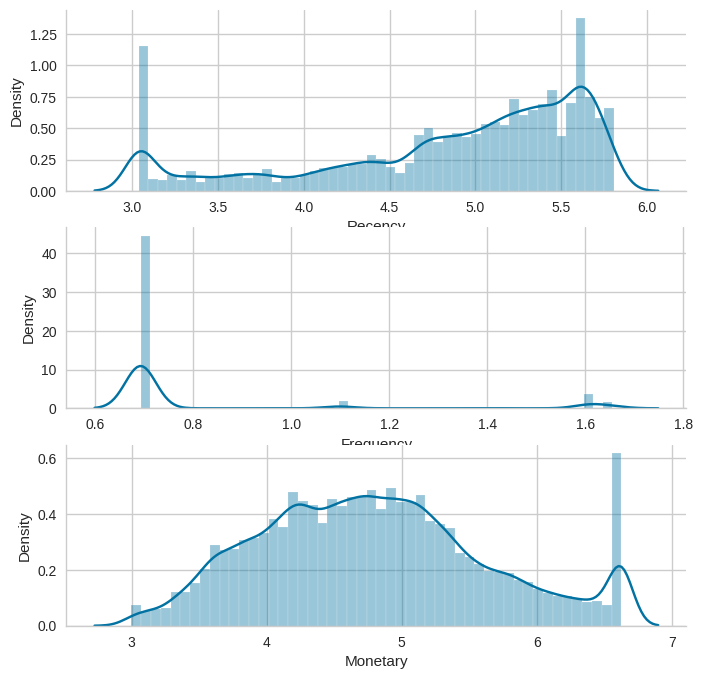

In [ ]:
# distribution of RFM after windsoriser
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(8, 8));
sns.despine(left=False, bottom=False)
sns.distplot(rfm_log['Recency'], ax=ax[0])
sns.distplot(rfm_log['Frequency'], ax=ax[1])
sns.distplot(rfm_log['Monetary'], ax=ax[2])
plt.show()

## Data Scaling

In [ ]:
scaler = StandardScaler()

scaler.fit(rfm_log)

target_scaled = scaler.transform(rfm_log)

target_scaled = pd.DataFrame(target_scaled, columns=rfm_log.columns)
target_scaled.head()

,Recency,Frequency,Monetary
0,1.193587,1.992535,-1.313516
1,-1.583763,-0.390858,0.199719
2,-2.199432,-0.390858,0.477574
3,0.998363,-0.390858,-0.589044
4,0.541095,-0.390858,-1.660776


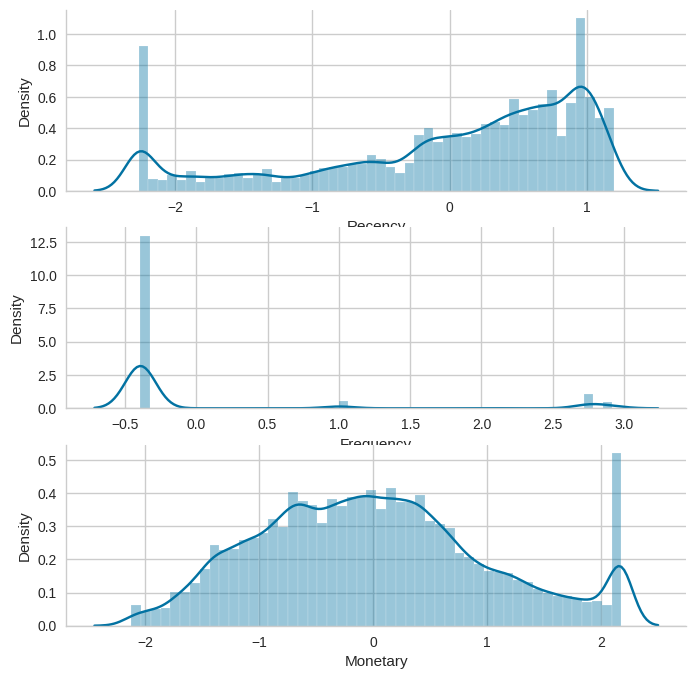

In [ ]:
# see the x axis after scaling
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(3, 1, figsize=(8, 8));
sns.despine(left=False, bottom=False)
sns.distplot(target_scaled['Recency'], ax=ax[0])
sns.distplot(target_scaled['Frequency'], ax=ax[1])
sns.distplot(target_scaled['Monetary'], ax=ax[2])
plt.show()

## Finding optimum number of *k*

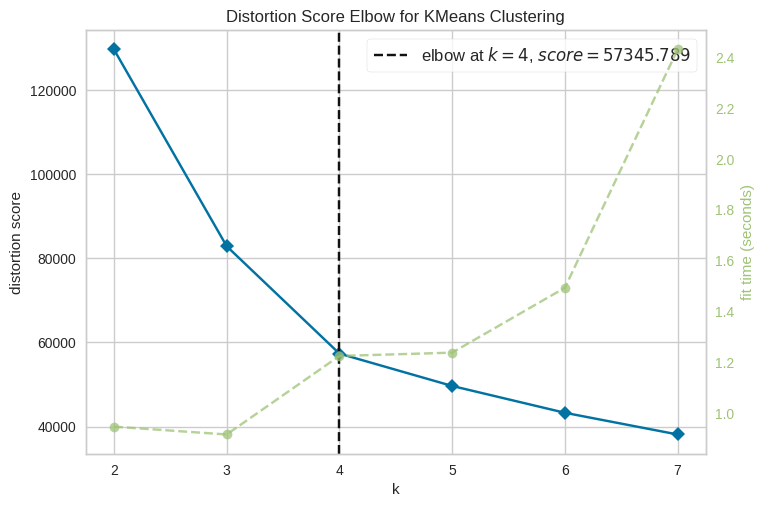

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#using Elbow Method
Elbow_fast = KElbowVisualizer(KMeans(random_state=42), k=7)
Elbow_fast.fit(target_scaled)
Elbow_fast.show()

#according to below plot, it would be better to use k=4

# KMeans Clustering

In [ ]:
#fit
kmeans_4 = KMeans(n_clusters=4, init='k-means++', max_iter=7)
kmeans_4.fit(target_scaled)

#predict
pred_4 = kmeans_4.predict(target_scaled)

#save it to origin preprocess_it df
rfm_clus['Cluster'] = pred_4

#save it to new df
clus_result = rfm_clus
clus_result

,Recency,Frequency,Monetary,Cluster
customer_unique_id,,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,3
af07308b275d755c9edb36a90c618231,35,1,141.46,2
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,2
7c142cf63193a1473d2e66489a9ae977,283,1,72.20,3
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,3
...,...,...,...,...
a49e8e11e850592fe685ae3c64b40eca,252,1,71.04,3
c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58,1
da62f9e57a76d978d02ab5362c509660,204,1,195.00,0


In [ ]:
#model evaluation
X = np.asarray(target_scaled)

#evaluation for k=4
#using silhouette score
sil_score = silhouette_score(X, kmeans_4.labels_, metric='euclidean')
#using davies bouldin score
dav_score = davies_bouldin_score(X, kmeans_4.labels_)

print('Silhouette Score: %.3f' % sil_score)
print('Davies Bouldin Score: %.3f' % dav_score)

Silhouette Score: 0.403
Davies Bouldin Score: 0.813


## Method 1: Interpreting Clustering Result using Snake plot and Heatmap

In [ ]:
# Melt the clus_result dataset and reset the index
clus_result_melt = pd.melt(
  clus_result.reset_index(),
    id_vars = ['customer_unique_id', 'Cluster'],
    value_vars = ['Recency', 'Frequency', 'Monetary'],
    var_name = 'Metric',
    value_name = 'Value'
)
clus_result_melt

,customer_unique_id,Cluster,Metric,Value
0,7c396fd4830fd04220f754e42b4e5bff,3,Recency,331.00
1,af07308b275d755c9edb36a90c618231,2,Recency,35.00
2,3a653a41f6f9fc3d2a113cf8398680e8,2,Recency,21.00
3,7c142cf63193a1473d2e66489a9ae977,3,Recency,283.00
4,72632f0f9dd73dfee390c9b22eb56dd6,3,Recency,196.00
...,...,...,...,...
208762,a49e8e11e850592fe685ae3c64b40eca,3,Monetary,71.04
208763,c716cf2b5b86fb24257cffe9e7969df8,1,Monetary,213.58
208764,da62f9e57a76d978d02ab5362c509660,0,Monetary,195.00
208765,5097a5312c8b157bb7be58ae360ef43c,1,Monetary,882.32


In [ ]:
# Melt the clus_result dataset, add column 'RFM_level'
clus_result['RFM_Level'] = my_rfm['RFM_Level']
clus_result_melt_quantiles = pd.melt(
  my_rfm.reset_index(),
    id_vars = ['customer_unique_id', 'RFM_Level'],
    value_vars = ['Recency', 'Frequency', 'Monetary'],
    var_name = 'Metric',
    value_name = 'Value'
)

clus_result_melt_quantiles

,customer_unique_id,RFM_Level,Metric,Value
0,7c396fd4830fd04220f754e42b4e5bff,Middle,Recency,331.00
1,af07308b275d755c9edb36a90c618231,Middle,Recency,35.00
2,3a653a41f6f9fc3d2a113cf8398680e8,Middle,Recency,21.00
3,7c142cf63193a1473d2e66489a9ae977,Low,Recency,283.00
4,72632f0f9dd73dfee390c9b22eb56dd6,Low,Recency,196.00
...,...,...,...,...
208762,a49e8e11e850592fe685ae3c64b40eca,Middle,Monetary,71.04
208763,c716cf2b5b86fb24257cffe9e7969df8,Middle,Monetary,213.58
208764,da62f9e57a76d978d02ab5362c509660,Middle,Monetary,195.00
208765,5097a5312c8b157bb7be58ae360ef43c,Top,Monetary,882.32


Text(0, 0.5, 'Value')

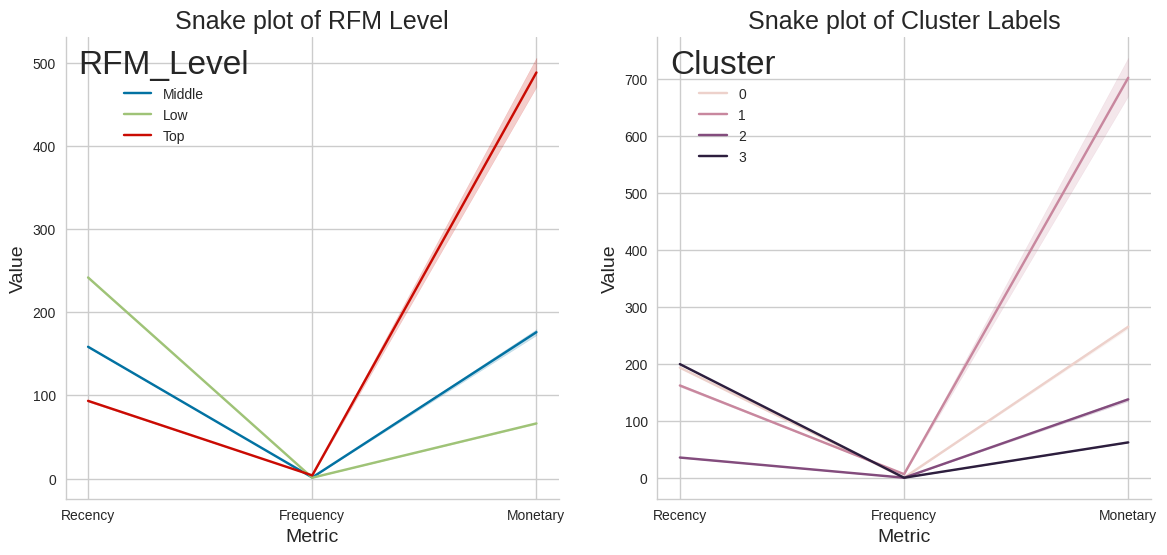

In [ ]:
# snake plot of RFM pattern in each cluster
fig, ax = plt.subplots(1, 2, figsize=(14,6))
sns.lineplot(data=clus_result_melt, x='Metric', y='Value', hue='Cluster', ax = ax[1])
sns.despine(left=False, bottom=False)
ax[1].set_title('Snake plot of Cluster Labels', fontsize = 18)
ax[1].set_xlabel('Metric', fontsize = 14)
ax[1].set_ylabel('Value', fontsize = 14)

# snake plot of RFM pattern in each RFM_Level
sns.lineplot(data=clus_result_melt_quantiles, x='Metric', y='Value', hue='RFM_Level', ax = ax[0])
sns.despine(left=False, bottom=False)
ax[0].set_title('Snake plot of RFM Level', fontsize = 18)
ax[0].set_xlabel('Metric', fontsize = 14)
ax[0].set_ylabel('Value', fontsize = 14)

In [ ]:
# Calculate relative importance of each attribute
# Calculate average RFM values for each cluster
RFM_k4_mean = clus_result.groupby(['Cluster'])[['Recency', 'Frequency', 'Monetary']].mean()

# Calculate average RFM values for the total customer population
Overall_mean = RFM_k4_mean.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = RFM_k4_mean / Overall_mean - 1

# Print relative importance score rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  Monetary
Cluster                              
0           0.31      -0.59     -0.09
1           0.10       1.79      1.40
2          -0.75      -0.60     -0.53
3           0.35      -0.60     -0.78


In [ ]:
# Calculate relative importance of each attribute
# Calculate average RFM values for each level
RFM_level_mean = my_rfm.groupby(['RFM_Level'])[['Recency', 'Frequency', 'Monetary']].mean()

# Calculate average RFM values for the total customer population
Overall_mean = RFM_level_mean.mean()

# Calculate relative importance of level's attribute value compared to population
relative_imp_level = RFM_level_mean / Overall_mean - 1

# Print relative importance score rounded to 2 decimals
print(relative_imp_level.round(2))

           Recency  Frequency  Monetary
RFM_Level                              
Low           0.47      -0.51     -0.73
Middle       -0.04      -0.35     -0.28
Top          -0.43       0.86      1.01


Text(145.72222222222223, 0.5, 'Level')

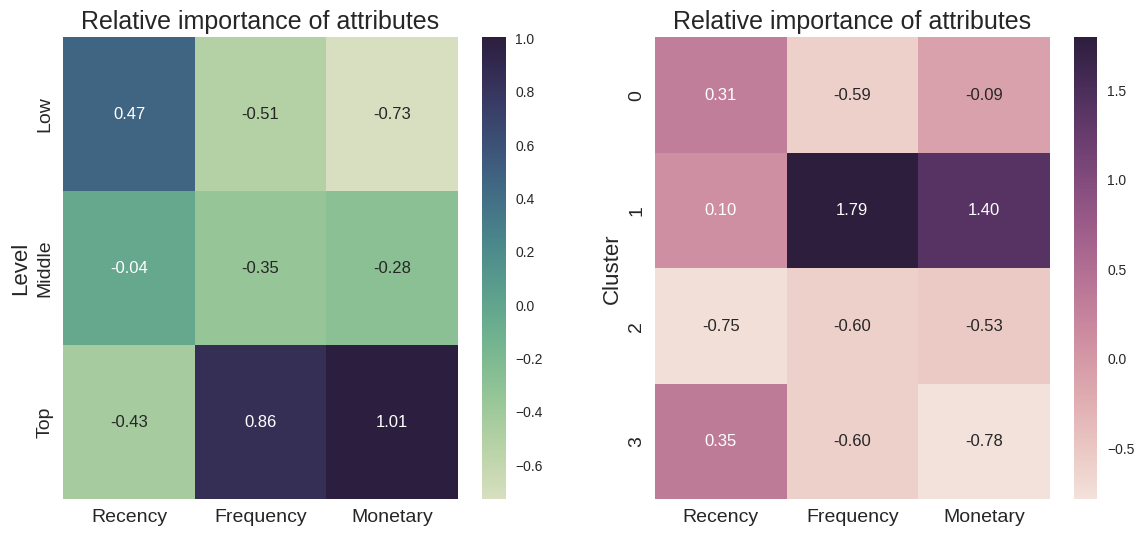

In [ ]:
# Heatmap
cmap = sns.cubehelix_palette(light=0.9, as_cmap=True)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap, ax=ax[1])
ax[1].set_title('Relative importance of attributes', fontsize=18)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_ylabel('Cluster', fontsize=16)

cmap2 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
sns.heatmap(data=relative_imp_level, annot=True, fmt='.2f', cmap=cmap2, ax=ax[0])
ax[0].set_title('Relative importance of attributes', fontsize=18)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel('Level', fontsize=16)

## Method 2: Interpreting clustering result using common method

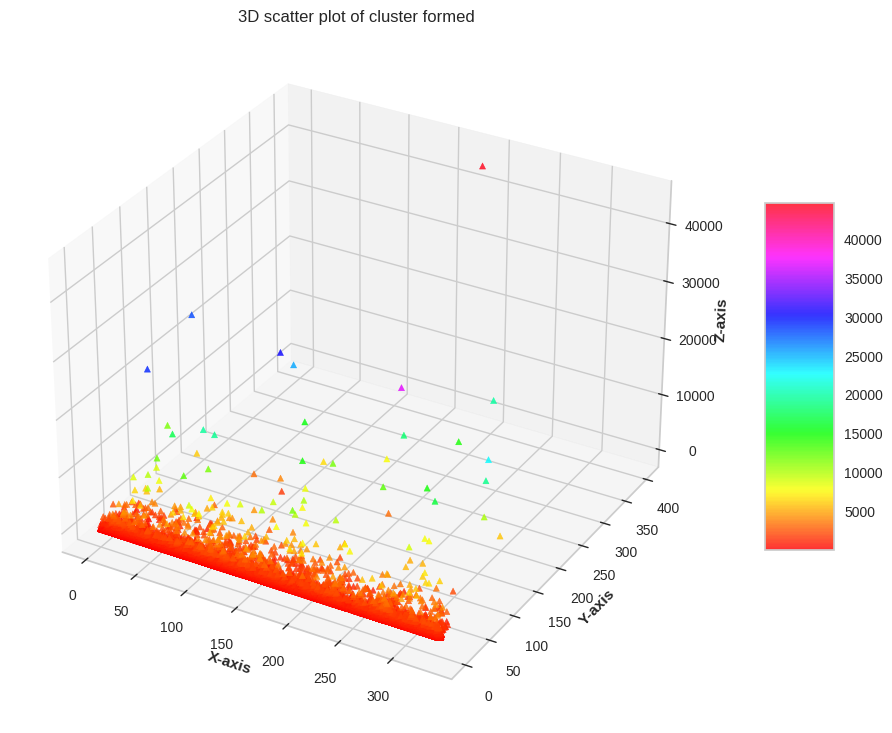

In [ ]:
x = clus_result["Recency"]
y = clus_result["Frequency"]
z = clus_result["Monetary"]

#Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

#Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

#Creating color map
cmap_ = plt.get_cmap('hsv')

#Creating plot
scatter = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = (x + y + z),
                    cmap = cmap_,
                    marker ='^')

plt.title("3D scatter plot of cluster formed")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(scatter, ax = ax, shrink = 0.5, aspect = 5)

#show plot
plt.show()

In [ ]:
#aggregate features in each cluster (onfly using mean)
def clusters_char(df):

    k4_result = clus_result.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
    })

    return k4_result

In [ ]:
#show the result
final_result = clusters_char(clus_result)
#final_result.reset_index()
final_result

,Recency,Frequency,Monetary
Cluster,,,
0,194.123138,1.052396,265.112548
1,162.669162,7.242748,701.954138
2,36.421906,1.041887,138.467844
3,200.085711,1.031809,62.857747


***Manually assign RFM classes to each cluster***

* Cluster 0: R=2 F=1 M=4 >> Active
* Cluster 1: R=2 F=4 M=4 >> Superior
* Cluster 2: R=4 F=1 M=3 >> Casual
* Cluster 3: R=2 F=1 M=2 >> Dormant

Order: Dormant < Casual < Active < Superior

In [ ]:
clus_result['Cluster']  = clus_result['Cluster'].map({
    0: 'Active',
    1: 'Superior',
    2: 'Casual',
    3: 'Dormant'
})

In [ ]:
# Function to visualize clusters
def rfm_clusters_stat(df):
    df_stats = df.groupby(['Cluster']).agg({
            'Recency'  : ['mean','median', 'min', 'max'],
            'Frequency': ['mean','median', 'min', 'max'],
            'Monetary' : ['mean','median', 'min', 'max', 'count']
        }).round(4)

    return df_stats

In [ ]:
#show the result
sum_stats = rfm_clusters_stat(clus_result)
#final_result.reset_index()
sum_stats

Recency                 Frequency                  Monetary  \
              mean median min  max      mean median min  max      mean   
Cluster                                                                  
Active    194.1231  190.0  41  332    1.0524    1.0   1    2  265.1125   
Casual     36.4219   33.0   0   88    1.0419    1.0   1    4  138.4678   
Dormant   200.0857  199.0  55  332    1.0318    1.0   1    5   62.8577   
Superior  162.6692  160.0   0  332    7.2427    4.0   2  400  701.9541   

                                           
          median     min       max  count  
Cluster                                    
Active    181.78  106.39   4681.78  22349  
Casual     99.80    9.59   6922.21  13823  
Dormant    61.77   10.89    112.55  25936  
Superior  383.66   22.32  44048.00   7481

In [ ]:
sum_stats.style.background_gradient(cmap='YlGnBu')

In [ ]:
#how many member in each cluster?
clus_result['Cluster'].value_counts()

Dormant     25936
Active      22349
Casual      13823
Superior     7481
Name: Cluster, dtype: int64

<Axes: >

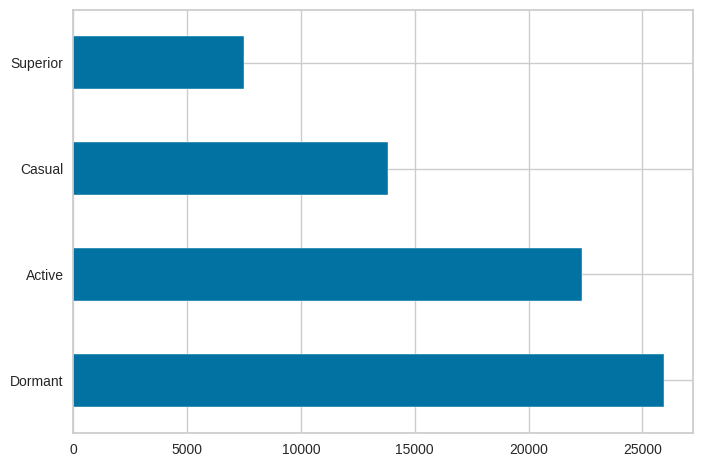

In [ ]:
#bar plot of how many member in each cluster?
total = clus_result['Cluster'].value_counts()
total.plot.barh()

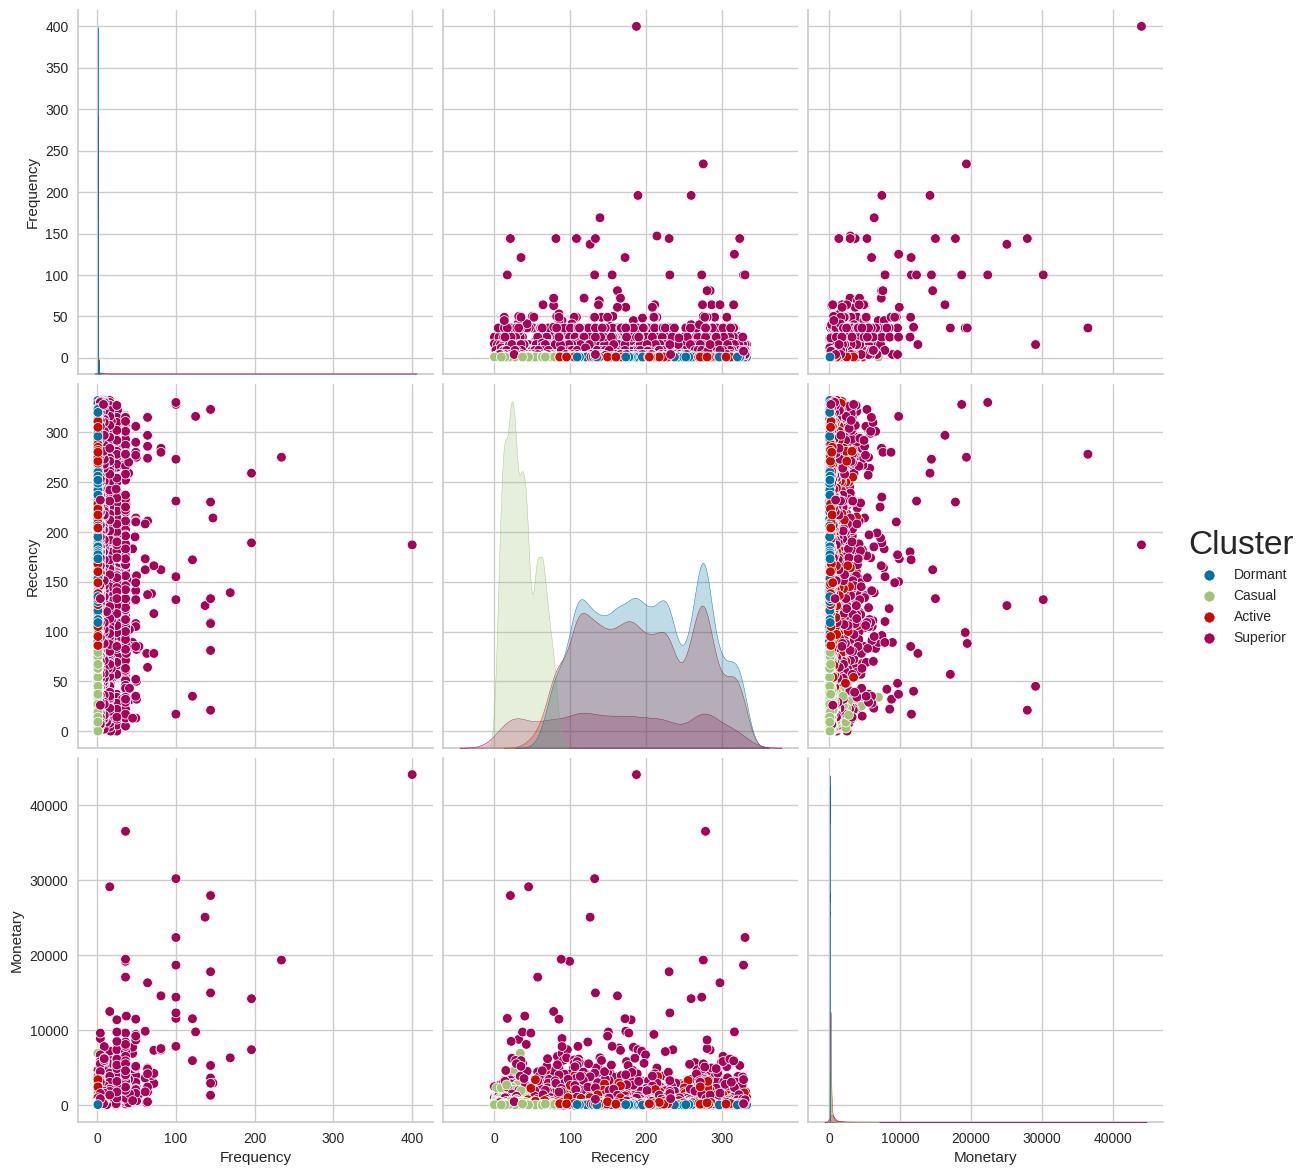

In [ ]:
fig = px.scatter_matrix(clus_result,
                        dimensions = ['Recency', 'Frequency','Monetary'],
                        color = 'Cluster',
                        symbol = 'Cluster',
                        # mapbox_style = "stamen-watercolor",
                        # color_discrete_map = dict(red= 1, blue=0),
                        width=1000, height=1000
                        )
fig.update_traces(diagonal_visible=True)
fig.show()

sns.pairplot(data=clus_result[['Frequency', 'Recency', 'Monetary', 'Cluster']], hue='Cluster', height=4)

# this plot is so weird, remind the fact that superior member should be the least one. In this plot, they're dominated the plot